# Where's the Bayes?

In my last notebook, I showed how to
[estimate errors](http://nbviewer.ipython.org/github/DougBurke/sherpa-standalone-notebooks/blob/master/simulating%20a%202D%20image%20and%20a%20bit%20of%20error%20analysis.ipynb)
for a simulated 2D data set, using the object API of Sherpa. This analysis lies in
the frequentist camp, so to show that Sherpa has no biases (the rather-poor pun intended),
this notebook is going to highlight a more Bayesian style of analysis. It takes advantage
of the 
[Bayesian Low-Count X-ray Spectral (pyBLoCXS) module](http://hea-www.harvard.edu/astrostat/pyblocxs/) - this documentation is slightly out-of-date, as the code is now part
of Sherpa, but we don't yet have this documentation written for the standalone release
of Sherpa - which is based on the work of
[van Dyk et al, 2001, ApJ, 548, 224](http://adslabs.org/adsabs/abs/2001ApJ...548..224V/)
but with a different Monte Carlo Markov Chain (MCMC) sampler
One of the main differences to many other MCMC schemes available in Python is that this
analysis is run "from the best-fit" location, which requires using the standard fit machinery
in Sherpa. It does let me do a quick comparison of the error estimates though (at the cost of using imprecise and probably statistically-inaccurate terminology, as 
[IANAS](https://news.ycombinator.com/item?id=3609715))! Note that I am more interested - in *this notebook* - in showing how to do things, and not in what they might actually mean
(I just came across
[Computational Methods in Bayesian Analysis](https://plot.ly/ipython-notebooks/computational-bayesian-analysis/), which was released last week, which might be of interest for explaining
the background to MCMC anal).

This time I shall also be using the 
[`triangle_plot` module](https://github.com/dfm/triangle.py)
for creating a nifty view of the
results of the MCMC analysis. This was installed with a call to

    pip install triangle_plot

## Author and disclaimer

This was written by 
[Douglas Burke](http://hea-www.cfa.harvard.edu/~dburke/)
on June 22 2015. This notebook, and others that may be of
interest, can be found on GitHub at
https://github.com/DougBurke/sherpa-standalone-notebooks.

The information in this document is placed into the Publc Domain. It is not an official product of the Chandra
X-ray Center, and I make no guarantee that it is not without bugs or embarassing typos. Please contact me via the GitHub repository or on Twitter - at 
[@doug_burke](https://twitter.com/doug_burke) - if you have any questions. 

## Setting up the environment

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

I am going to use a different seed for the NumPy random generator to last time (when I used 1):

In [3]:
np.random.seed(2)

The following is just to avoid seeing some repeated screen messages from the error analysis routines in Sherpa:

In [4]:
import logging
logging.getLogger('sherpa').propagate = False

For the record, I am using the following version of Sherpa - as this is from the master branch of the [GitHub repository](https://github.com/sherpa/sherpa/) it includes the commit value. In
this case it is 
[57e2d92](https://github.com/sherpa/sherpa/tree/57e2d920414eb5e0a032143c836569cb364c6f94):

In [5]:
import sherpa
print(sherpa.__version__)

4.7+427.g57e2d92


## Simulating the data

I am going to use the same model as
[last time](http://nbviewer.ipython.org/github/DougBurke/sherpa-standalone-notebooks/blob/master/simulating%20a%202D%20image%20and%20a%20bit%20of%20error%20analysis.ipynb#Simulating-data):

In [6]:
x1low = 4000
x1high = 4800

x0low = 3000
x0high = 4000

dx = 5

x1,x0 = np.mgrid[x1low:x1high:dx, x0low:x0high:dx]

from sherpa.astro.models import Beta2D

cpt1 = Beta2D('cpt1')
cpt2 = Beta2D('cpt2')
model = cpt1 + cpt2

cpt1.xpos, cpt1.ypos = 3512, 4418
cpt2.xpos, cpt2.ypos = cpt1.xpos, cpt1.ypos

cpt1.r0, cpt2.r0 = 30, 120
cpt1.alpha, cpt2.alpha = 4.2, 2.1

cpt1.ampl, cpt2.ampl = 45, 10

mexp = model(x0.flatten(), x1.flatten())
mexp.resize(x0.shape)

msim = np.random.poisson(mexp)

Let's have a quick look to make sure my copy and paste skills are still top notch:

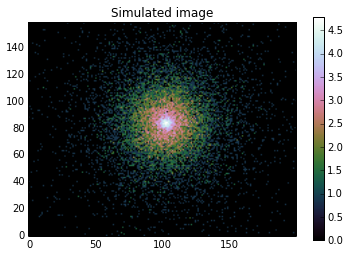

In [7]:
plt.imshow(np.arcsinh(msim), origin='lower', cmap='cubehelix')
plt.title('Simulated image')
_ = plt.colorbar()

## Fitting the data

This is also remarkably similar to 
[last time](http://nbviewer.ipython.org/github/DougBurke/sherpa-standalone-notebooks/blob/master/simulating%20a%202D%20image%20and%20a%20bit%20of%20error%20analysis.ipynb#Fitting-the-data):

In [8]:
from sherpa.data import Data2D
from sherpa.stats import Cash
from sherpa.optmethods import NelderMead
from sherpa.fit import Fit

In [9]:
d = Data2D('sim', x0.flatten(), x1.flatten(), msim.flatten(), shape=x0.shape)

In [10]:
mdl_fit = Beta2D('m1') + Beta2D('m2')
(m1, m2) = mdl_fit.parts

In [11]:
ysum = msim.sum(axis=0)
xsum = msim.sum(axis=1)

In [12]:
xguess = x0[0,np.argmax(ysum)]
yguess = x1[np.argmax(xsum),0]

In [13]:
m1.xpos = xguess
m1.ypos = yguess
m2.xpos = m1.xpos
m2.ypos = m1.ypos

In [14]:
m1.ampl = msim.max()
m2.ampl = msim.max() / 10.0

In [15]:
x1max = x1.max()
x1min = x1.min()

m1.r0 = (x1max-x1min) / 10.0
m2.r0 = (x1max-x1min) / 4.0

In [16]:
f = Fit(d, mdl_fit, Cash(), NelderMead())

In [17]:
res1 = f.fit()
print(res1)

datasets       = None
itermethodname = none
methodname     = neldermead
statname       = cash
succeeded      = True
parnames       = ('m1.r0', 'm1.xpos', 'm1.ypos', 'm1.ampl', 'm1.alpha', 'm2.r0', 'm2.ampl', 'm2.alpha')
parvals        = (25.341929451439281, 3511.5508398922098, 4417.8814972491573, 44.749701359099248, 3.0349134055618241, 128.66066231787082, 9.3411196647053583, 2.1876131362888724)
statval        = 1799.93002111
istatval       = 357450.453643
dstatval       = 355650.523622
numpoints      = 32000
dof            = 31992
qval           = None
rstat          = None
message        = Optimization terminated successfully
nfev           = 3206


In [18]:
res2 = f.fit()
print(res2.format())

Method                = neldermead
Statistic             = cash
Initial fit statistic = 1799.93
Final fit statistic   = 1799.93 at function evaluation 619
Data points           = 32000
Degrees of freedom    = 31992
Change in statistic   = 1.06866e-11
   m1.r0          25.3419     
   m1.xpos        3511.55     
   m1.ypos        4417.88     
   m1.ampl        44.7497     
   m1.alpha       3.03491     
   m2.r0          128.661     
   m2.ampl        9.34112     
   m2.alpha       2.18761     


The first difference is that I need the covariance matrix for the MCMC run, as the routine uses this to determine the parameter jumps. I've decided to go all out and also run the covariance routine, so that we can compare error estimates from three methods:

In [19]:
from sherpa.estmethods import Covariance, Confidence

First the covariance, which is quite quick to calculate:

In [20]:
f.estmethod = Covariance()
covar_res = f.est_errors()
print(covar_res)

datasets    = None
methodname  = covariance
iterfitname = none
fitname     = neldermead
statname    = cash
sigma       = 1
percent     = 68.2689492137
parnames    = ('m1.r0', 'm1.xpos', 'm1.ypos', 'm1.ampl', 'm1.alpha', 'm2.r0', 'm2.ampl', 'm2.alpha')
parvals     = (25.341911322670395, 3511.5508399883333, 4417.8814972274331, 44.749705531760668, 3.0349102014446814, 128.66066838343579, 9.3411187595940675, 2.1876131680724042)
parmins     = (-6.7116233510208945, -0.40358351104033852, -0.39582122494382282, -3.3791779267575524, -1.1671506278342894, -4.8666247649225225, -0.4503534611323351, -0.05448093373622747)
parmaxes    = (6.7116233510208945, 0.40358351104033852, 0.39582122494382282, 3.3791779267575524, 1.1671506278342894, 4.8666247649225225, 0.4503534611323351, 0.05448093373622747)
nfits       = 0


In [21]:
print(covar_res.format())

Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = neldermead
Statistic             = cash
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   m1.r0             25.3419     -6.71162      6.71162
   m1.xpos           3511.55    -0.403584     0.403584
   m1.ypos           4417.88    -0.395821     0.395821
   m1.ampl           44.7497     -3.37918      3.37918
   m1.alpha          3.03491     -1.16715      1.16715
   m2.r0             128.661     -4.86662      4.86662
   m2.ampl           9.34112    -0.450353     0.450353
   m2.alpha          2.18761   -0.0544809    0.0544809


What I need is the covariance matrix, which is stored in the `extra_output` field of the structure:

In [22]:
print(covar_res.extra_output)

[[  4.50458880e+01   1.40448506e-01   1.36235576e-01  -1.73441288e+01
    7.75530737e+00  -2.00829963e+01   2.27325720e+00  -1.73986391e-01]
 [  1.40448506e-01   1.62879650e-01  -4.00668672e-04  -7.91245134e-02
    2.16684083e-02  -4.21443369e-02   4.71654369e-03  -3.71518293e-04]
 [  1.36235576e-01  -4.00668672e-04   1.56674442e-01  -9.11565572e-02
    1.93485690e-02  -1.63035047e-02   2.31721963e-03  -1.19341653e-04]
 [ -1.73441288e+01  -7.91245134e-02  -9.11565572e-02   1.14188435e+01
   -2.74248683e+00   6.54505357e+00  -7.38300068e-01   5.69376486e-02]
 [  7.75530737e+00   2.16684083e-02   1.93485690e-02  -2.74248683e+00
    1.36224059e+00  -3.79150343e+00   4.24201933e-01  -3.31344698e-02]
 [ -2.00829963e+01  -4.21443369e-02  -1.63035047e-02   6.54505357e+00
   -3.79150343e+00   2.36840366e+01  -2.00279046e+00   2.52775269e-01]
 [  2.27325720e+00   4.71654369e-03   2.31721963e-03  -7.38300068e-01
    4.24201933e-01  -2.00279046e+00   2.02818240e-01  -1.87824908e-02]
 [ -1.7398639

It's probably a bit-more instructive to view this as an image (I wrote a function here since I'm going to re-display this image later on):

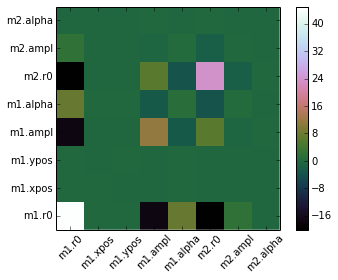

In [23]:
parnames = [p.fullname for p in mdl_fit.pars if not p.frozen]

def image_covar():
    plt.imshow(covar_res.extra_output, cmap='cubehelix', interpolation='none', origin='lower')
    idxs = np.arange(0, len(parnames))
    plt.xticks(idxs, parnames, rotation=45)
    plt.yticks(idxs, parnames)
    plt.colorbar()
    
image_covar()

The confidence errors can also be calculated (unfortunately they take *significantly longer* to calculate than the covariance-derived errors). Note that, unlike 
[last time](http://nbviewer.ipython.org/github/DougBurke/sherpa-standalone-notebooks/blob/master/simulating%20a%202D%20image%20and%20a%20bit%20of%20error%20analysis.ipynb#Error-analysis), I
do not change the optimisation method to `LevMar` when calculating the errors):

In [24]:
f.estmethod = Confidence()
conf_res = f.est_errors()
print(conf_res.format())

Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = neldermead
Statistic             = cash
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   m1.r0             25.3419     -5.55611       8.8833
   m1.xpos           3511.55    -0.403584     0.403584
   m1.ypos           4417.88    -0.395821     0.395821
   m1.ampl           44.7497     -3.19362       3.5909
   m1.alpha          3.03491    -0.878786       1.7768
   m2.r0             128.661     -4.56668      5.20759
   m2.ampl           9.34112    -0.500062     0.414424
   m2.alpha          2.18761   -0.0522932    0.0569812
m1.ypos lower bound:	-0.395821
m1.xpos lower bound:	-0.403584
m1.ampl lower bound:	-3.19362
m2.r0 lower bound:	-4.56668
m2.ampl lower bound:	-0.500062
m1.r0 lower bound:	-5.55611
m1.alpha lower bound:	-0.878786
m2.alpha lower bound:	-0.0522932
m1.ypos upper bound:	0.395821
m1.xpos up

## Running the MCMC

For this example I am going to run the *simplest* chain possible; that is, I am not going to add any additional priors on the parameter values (so they assume a flat distribution), and use the Metropolis-Hastings sampler with its default settings.

In [25]:
from sherpa.sim import MCMC

In [26]:
mcmc = MCMC()

In [27]:
mcmc.get_sampler_name()

'MetropolisMH'

The one thing I do change is the number of iterations (the default is 1000), to quite a large number, so this step takes a while to complete:

In [28]:
niter = 100000
draws = mcmc.get_draws(f, covar_res.extra_output, niter=niter)

Using Priors:
m1.r0: <function flat at 0x7fd6848ad578>
m1.xpos: <function flat at 0x7fd6848ad578>
m1.ypos: <function flat at 0x7fd6848ad578>
m1.ampl: <function flat at 0x7fd6848ad578>
m1.alpha: <function flat at 0x7fd6848ad578>
m2.r0: <function flat at 0x7fd6848ad578>
m2.ampl: <function flat at 0x7fd6848ad578>
m2.alpha: <function flat at 0x7fd6848ad578>


The return value from `get_draws` contains an array of the statistic values, a boolean flag for each iteration saying whether the proposed jump was accepted or not, and the parameter values for each step:

In [29]:
stats, accept, pars = draws

The length of these arrays is `niter+1`, since the first element is the starting value:

In [30]:
len(stats)

100001

First things first; let's look at the acceptance ratio of the full chain (I'm ignoring the fact that `niter` != `niter+1` here as it's not going to significantly change the results):

In [31]:
accept.sum() * 1.0 / accept.size

0.15888841111588883

This is a bit lower than I'd expect, but let's soldier on. First, let's see how the statistic varies across this run:

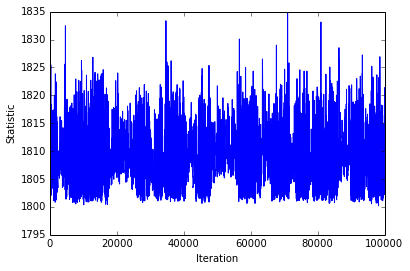

In [32]:
plt.plot(stats)
plt.xlabel('Iteration')
_ = plt.ylabel('Statistic')

Hopw about the parameter values? The third element returned by `get_draws` is a 2D array, with dimensions being the number of parameters and `niter+1`:

In [33]:
pars.shape

(8, 100001)

The order of the parameters is as given by the model. This can be accessed several ways; here I use the fit object to access its copy of the model:

In [34]:
f.model.pars

(<Parameter 'r0' of model 'm1'>,
 <Parameter 'xpos' of model 'm1'>,
 <Parameter 'ypos' of model 'm1'>,
 <Parameter 'ellip' of model 'm1'>,
 <Parameter 'theta' of model 'm1'>,
 <Parameter 'ampl' of model 'm1'>,
 <Parameter 'alpha' of model 'm1'>,
 <Parameter 'r0' of model 'm2'>,
 <Parameter 'xpos' of model 'm2'>,
 <Parameter 'ypos' of model 'm2'>,
 <Parameter 'ellip' of model 'm2'>,
 <Parameter 'theta' of model 'm2'>,
 <Parameter 'ampl' of model 'm2'>,
 <Parameter 'alpha' of model 'm2'>)

Note that this array includes all the model parameters, including those that were frozen in the fit. I am going to iterate through this a few times below, so I'm going to digress for one notebook cell, showing you how to access some of the parameter values:

In [35]:
for par in f.model.pars:
    lbl = "Model {}  Component={:5s} val = {:7.2f}".format(par.modelname,
                                                           par.name,
                                                           par.val)
    if par.frozen:
        lbl += " IS FROZEN"
    
    print(lbl)

Model m1  Component=r0    val =   25.34
Model m1  Component=xpos  val = 3511.55
Model m1  Component=ypos  val = 4417.88
Model m1  Component=ellip val =    0.00 IS FROZEN
Model m1  Component=theta val =    0.00 IS FROZEN
Model m1  Component=ampl  val =   44.75
Model m1  Component=alpha val =    3.03
Model m2  Component=r0    val =  128.66
Model m2  Component=xpos  val = 3511.55 IS FROZEN
Model m2  Component=ypos  val = 4417.88 IS FROZEN
Model m2  Component=ellip val =    0.00 IS FROZEN
Model m2  Component=theta val =    0.00 IS FROZEN
Model m2  Component=ampl  val =    9.34
Model m2  Component=alpha val =    2.19


The first parameter is the core radius of the first component, so let's plot this: 

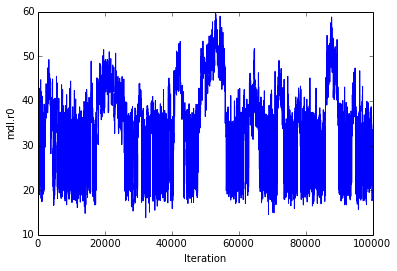

In [36]:
plt.plot(pars[0,:])
plt.xlabel('Iteration')
_ = plt.ylabel('mdl.r0')

Looking at this - and the trace of the statistic, above - suggests that there may be several modes (i.e. local minima around the best fit location). I can plot a trace of all the parameters for more information (apologies for the collisions on the Y-axis ranges):

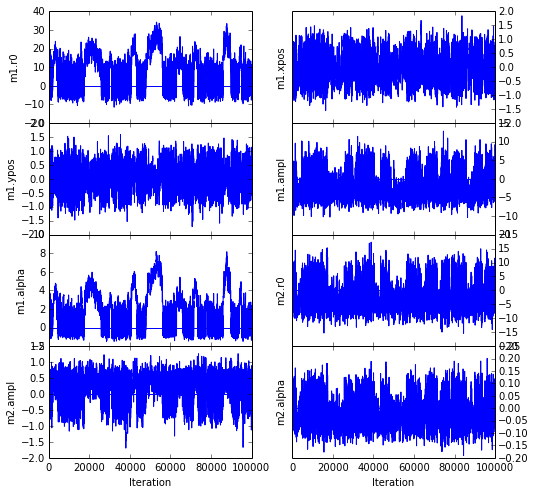

In [37]:
for i,par in enumerate([p for p in f.model.pars if not p.frozen]):

    plt.subplot(4,2,i+1)
    plt.plot(pars[i,:] - par.val)
    plt.axhline(0)
    plt.ylabel(par.fullname)
    ax = plt.gca()
    if i > 5:
        plt.xlabel('Iteration')
    else:
        ax.get_xaxis().set_ticklabels([])

    if i % 2 == 1:
        ax.get_yaxis().tick_right()
        
fig = plt.gcf()
fig.subplots_adjust(hspace=0)
fig.set_size_inches(8,8)

Normally you would care about removing a burn in period from the data. Given that the fit starts at the "best-fit" location, the size of the burn in should be small. I am going to use the arbitrarily-chosen value of `1000`, since this notebook is just for exploring the API.

In [38]:
burnin = 1001
accept[burnin:].sum() * 1.0 / accept[burnin:].size

0.15887878787878787

So, the acceptance rate isn't really any different after removing my burnin period.

Scatter plots can be used to investigate any possible correlations. For instance, from above `m1.r0` and `m1.alpha` appear to be strongly correlated (which is expected, given the functional form of the Beta2D model):

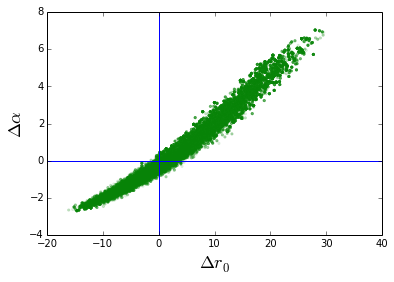

In [39]:
plt.scatter(pars[0,burnin:] - cpt1.r0.val,
            pars[4,burnin:] - cpt1.alpha.val,
            alpha=0.1, color='green', marker='.')

plt.axhline(0)
plt.axvline(0)

plt.xlabel(r'$\Delta r_0$', size=18)
_ = plt.ylabel(r'$\Delta \alpha$', size=18)

Sherpa provides objects for creating and showing the traces (`sherpa.plot.Traceplot`)
and scatter plots (`sherpa.plot.ScatterPlot`), but as shown above they're easy to also
create directly. There are some more-involving plots that I'd like to look at, so I am
going to use Sherpa's versions of the Probability Density and Cumulative Distribution
functions (PDF and CDF respectively):

In [40]:
from sherpa.plot import PDFPlot, CDFPlot

Here's the PDF of the `m1.r0` chain (not normalised, so not actually a PDF, but I'm going to refer to it as such), with error bars from the covariance and confidence methods added on, and the true value displayed as the vertival black line: 

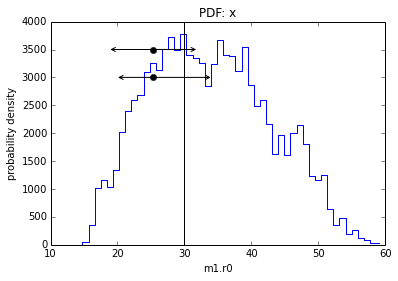

In [41]:
pdf = PDFPlot()
pdf.prepare(pars[0,burnin:], 50, False, 'm1.r0')
pdf.plot()

# the true value, as a black line
plt.axvline(cpt1.r0.val, color='k')

def add_errorbar(errs, idx, y):
    """Add an error bar using index idx of the error structure errs."""

    loval = errs.parvals[idx] + errs.parmins[idx]
    hival = errs.parvals[idx] + errs.parmaxes[idx]

    plt.annotate('', (loval, y), (hival, y),
                 arrowprops={'arrowstyle': '<->'})
    plt.plot([covar_res.parvals[idx]], [y], 'ok')

# add on the error ranges from covariance and confidence analysis
add_errorbar(covar_res, 0, 3500)
add_errorbar(conf_res, 0, 3000)

To my eye, the standard Sherpa error analysis appears to have caught the first peak, but do not really account for subsidiary peaks (eg at around 35-40 and 45-50) - which isn't too surprising given the assumptions they rely upon - but my aim in this notebook is to show *how*, and to leave the *why* to another time.

The CDF can be created in a similar manner (with the same annotations). In this case the vertical lines indicate the $\pm1 \sigma$ range around the median.

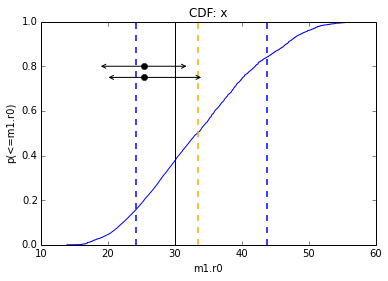

In [42]:
cdf = CDFPlot()
cdf.prepare(pars[0,burnin:], 'm1.r0')
cdf.plot()
plt.axvline(cpt1.r0.val, color='k')

add_errorbar(covar_res, 0, 0.8)
add_errorbar(conf_res, 0, 0.75)

Looking at these trace by trace, or pair by pair, is inefficient, and its easy to 
miss something. So, I'm going to use [`triangle` module](https://github.com/dfm/triangle.py)
to display all the pair-wise correlations. 

In [43]:
import triangle

One of the things I will need is an array of the "true" values, as defined by the `model` expression:

In [44]:
parvals = [p.val for p in model.pars if not p.frozen]
print(parvals)

[30.0, 3512.0, 4418.0, 45.0, 4.2000000000000002, 120.0, 10.0, 2.1000000000000001]


With this, I can create a triangle plot. Note that I have captured the return
value of `triangle.corner` otherwise the notebook decides to display the figure
twice (I am not sure why, I also accidentally re-ran this cell twice, which is why
there's no cell number 45):

Quantiles:
[(0.16, 24.255546051145579), (0.5, 33.382754059327041), (0.84, 43.688288009746721)]
Quantiles:
[(0.16, 3511.1520349358443), (0.5, 3511.5568168157452), (0.84, 3511.9583643010824)]
Quantiles:
[(0.16, 4417.50960921775), (0.5, 4417.9012564606592), (0.84, 4418.2852071876887)]
Quantiles:
[(0.16, 40.114324294719907), (0.5, 42.834255301316183), (0.84, 46.111039127912484)]
Quantiles:
[(0.16, 2.8452203449218412), (0.5, 4.6527896617098792), (0.84, 7.1981255764085423)]
Quantiles:
[(0.16, 122.86467409497442), (0.5, 126.71715167783438), (0.84, 130.9471751056833)]
Quantiles:
[(0.16, 9.1818853148860615), (0.5, 9.5699109924910175), (0.84, 9.8896067414944913)]
Quantiles:
[(0.16, 2.1238317615233346), (0.5, 2.1709804922096798), (0.84, 2.2204566419804057)]


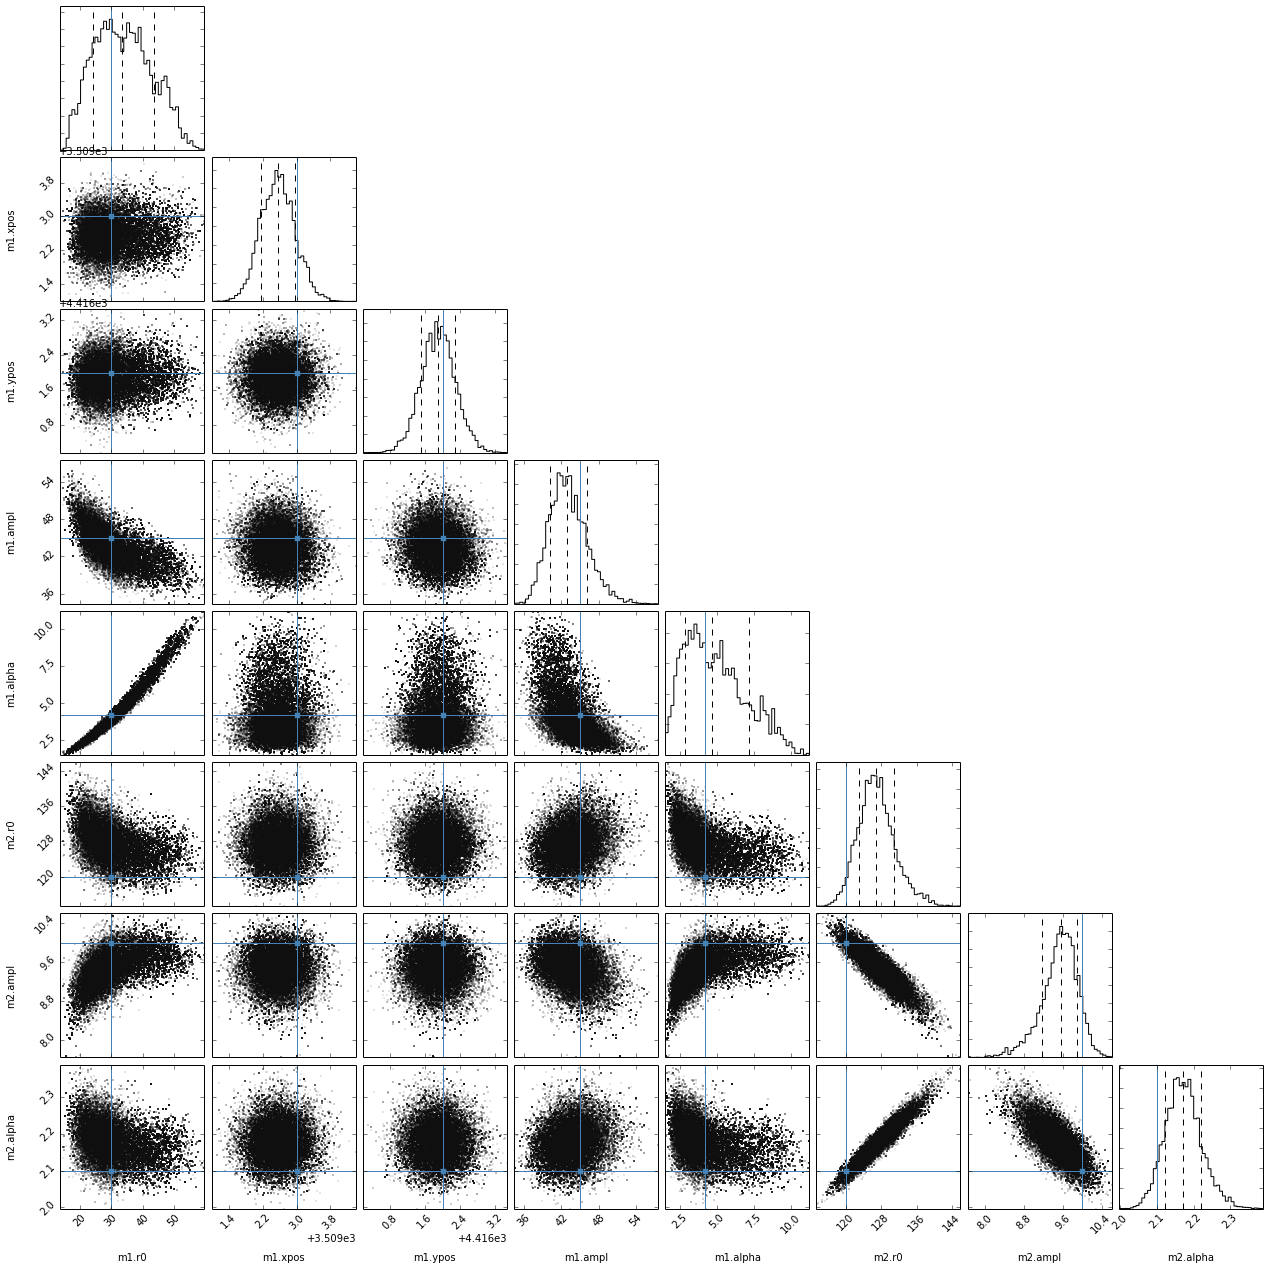

In [46]:
fig = triangle.corner(pars[:,burnin:].T, labels=parnames,
                      quantiles=[0.16, 0.5, 0.84],
                      plot_contours=False, truths=parvals)

The histogram plots along the diagonal show the equivalent of the PDF plot I showed earlier, with the dotted vertical lines showing the -1 sigma, median, and +1 sigma values. The blue lines show the true values for these parameters.

For comparison, here's the covariance matrix I displayed earlier:

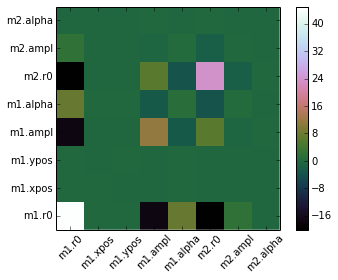

In [47]:
image_covar()

In the previous notebook, I showed how to use the
[region projection object](http://nbviewer.ipython.org/github/DougBurke/sherpa-standalone-notebooks/blob/master/simulating%20a%202D%20image%20and%20a%20bit%20of%20error%20analysis.ipynb#Region-Projection-%28this-time-with-two-variables%29)
to investigate how the statistic varies as a function of two parameters. In the following few cells I am going to overlay this contour plot on the scatter plot from the MCMC analysis, to see if they agree. For this analysis I start with the `m1.r0` and `m1.alpha` parameters, as they are strongly correlated:

In [48]:
from sherpa.plot import RegionProjection

In [49]:
rproj = RegionProjection()
rproj.prepare(min=(15,2), max=(55,10), nloop=(21,21))

The `calc` method takes a long time:

In [50]:
rproj.calc(f, m1.r0, m1.alpha)

The contour plot looks similar to the scatter plot shown earlier. I note that the
limited resolution of this analysis - namely a 21 by 21 grid - hasn't been able to properly resolve the search surface, as shown by the separated islands of the 1 sigma contour (dark blue).

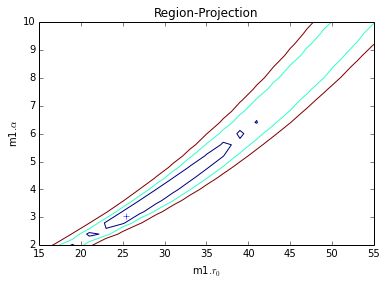

In [51]:
rproj.contour()
plt.xlabel('m1.$r_0$')
_ = plt.ylabel(r'm1.$\alpha$')

To compare it to the `triangle` view, I restrict the display to just these parameters, and change the region-projection plot to use green for the contour and best-fit location (to make them more visible) when drawn on top of the scatter plot):

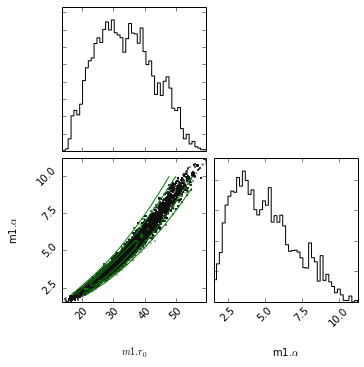

In [52]:
twopars = np.vstack([pars[0,burnin:],pars[4,burnin:]])
fig = triangle.corner(twopars.T, plot_contours=False, labels=['$m1.r_0$',r'm1.$\alpha$'])
plt.axes(fig.axes[2])
rproj.contour_prefs['colors'] = 'g'
rproj.point_prefs['color'] = 'g'
rproj.contour(overplot=True, clearwindow=False)

As the bottom-left plot is a scatter plot, and so does not show densities, it's impossible to directly compare the two, but at least they look similar. An attentive eye shows that the MCMC analysis has included a few points with `m1.alpha > 10` (for this analysis I just look at the whole chain, rather than excluding any burn in):

In [53]:
print("m1.alpha = {:.1f} to {:.1f}".format(pars[4].min(), pars[4].max()))

m1.alpha = 1.5 to 11.2


This is somewhat surprising given that `m1.alpha` is limited to `-10` to `+10`; I assume that 
the MCMC analysis can extend a value outside its soft limits, but please don't quote me on that.

I repeat the analysis, but this time for two parameters that are less-strongly correlated, namely `m1.r0` and `m2.r0`:

In [54]:
rproj2 = RegionProjection()
rproj2.prepare(min=(15,110), max=(60,145), nloop=(21,21))
rproj2.calc(f, m1.r0, m2.r0)

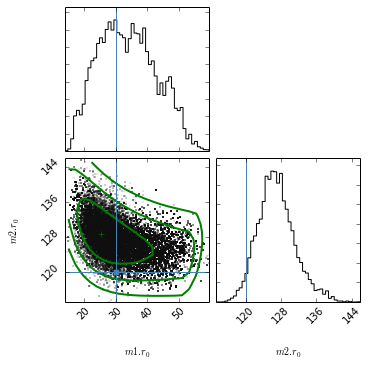

In [55]:
twopars2 = np.vstack([pars[0,burnin:],pars[5,burnin:]])
parvals2 = [parvals[0], parvals[5]]
fig = triangle.corner(twopars2.T, plot_contours=False,
                      labels=['$m1.r_0$',r'$m2.r_0$'],
                      truths=parvals2)
plt.axes(fig.axes[2])
rproj2.contour_prefs['colors'] = 'green'
rproj2.contour_prefs['linewidths'] = 2
rproj2.point_prefs['color'] = 'g'
rproj2.contour(overplot=True, clearwindow=False)

Again, the two sets of analysis (region-projection and MCMC) seem to be identifying the same structures.

I can also look at how the search surface (i.e. statistic value) and MCMC runs compare for a single parameter:

In [56]:
from sherpa.plot import IntervalProjection

In [57]:
iproj = IntervalProjection()
iproj.prepare(nloop=21, fac=3)

In [58]:
iproj.calc(f, m2.ampl)

The following plot shows the (this-time-normalized) PDF of the `m2.ampl` parameter as the solid black line
(note that this time I didn't give explicit limits, so it's going to pick some for me, 
although I have changed the `fac` parameter to give it some indication of the range I 
want to cover), and the statistic value (as a function of the parameter value) as the blue dotted line.

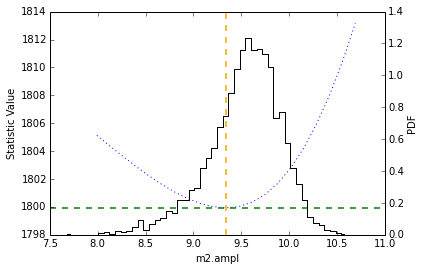

In [59]:
iproj.plot_prefs['linestyle'] = ':'
iproj.plot()
plt.title('')

ax = plt.gca()
ax2 = ax.twinx()
plt.axes(ax2)

pdf2 = PDFPlot()
pdf2.prepare(pars[6,burnin:], 50, True)
pdf2.histo_prefs['color'] = 'k'
pdf2.plot(overplot=True, clearwindow=False)
_ = ax2.set_ylabel('PDF')

So, you can see some correspondance between the density sampled by the MCMC and the statistic value sampled by the interval-projection routine, but the difference in the Y axes does make this hard to interpret! However, interpretation is not the intent of this notebook :-)